# Priprema i treniranje ALNP modela

U ovom notebooku ćemo pripremiti podatke za trening i trenirati ALNP - Atentivni Latentni Neuronski Proces. U prethodnoj svesci smo koristili SOM kako bismo filtrirali krive, i u ovoj svesci će korisniku biti ponuđeno da trenira model na svim podacima, ili samo na najvećem SOM klasteru.

In [1]:
import QNPy_Latte.PREPROCESS as pr
from QNPy_Latte.PREPROCESS import transform 
from QNPy_Latte.PREPROCESS import clean_outliers_median, backward_pad_curves 
import QNPy_Latte.SPLITTING_AND_TRAINING as st

import os
import glob 
import pandas as pd
import numpy as np
import torch
import shutil
import matplotlib.pyplot as plt

## 1. Učitavanje i priprema podataka

Ukoliko je `only_largest_cluster` postavljen na True, koriste se samo podaci iz najvećeg klastera dobijenog iz prethodnog notebooka. Kako je naš dataset jako mali, nije idealno trenirati na jedanaest krivih. Zato postoji i opcija da se trenira na celom skupu koji imamo.

In [2]:
only_largest_cluster = False
if only_largest_cluster:
    lc_dir = "output/Largest_Cluster_CSVs"
else:
    lc_dir = "Light_curves"

csv_files = glob.glob(lc_dir + "/*.csv")
df_list = (pd.read_csv(file) for file in csv_files)
data = pd.concat(df_list, ignore_index=True)

Čistimo outliere radi boljeg treniranja.

In [3]:
cleaned_path = f'output/Cleaned_LCs/'
clean_outliers_median(lc_dir, cleaned_path, median = True)

100%|██████████| 100/100 [00:00<00:00, 158.74it/s]

Light Curves Cleaned..


Kao i u prošloj svesci, radimo padding:

In [4]:
padding= pr.backward_pad_curves(cleaned_path, f'output/Padded_LCs', desired_observations=100,verbose=0)

Vršimo transformaciju i skaliranje podataka, nalik na način na koji smo to radili u prethodnom notebooku:

In [5]:
DATA_SRC = f"output/Padded_LCs" 
#path to folder to save preproc data (transformed data)
DATA_DST = f"output/preproc_LCs"
os.makedirs(DATA_DST,exist_ok=True)
files = os.listdir(DATA_SRC) 
os.makedirs('output/TR_Coeffs',exist_ok = True)
trcoeff_filename = f'output/TR_Coeffs/trcoeff_LCs.pickle'
number_of_points, trcoeff = pr.transform_and_save(files, DATA_SRC, DATA_DST, transform,trcoeff_file = trcoeff_filename)
shutil.rmtree(DATA_SRC)

Konačni korak pripreme je podela transformisanih podataka u tri skupa neophodna za obuku i evaluaciju modela: `train` (za učenje parametara), `validation` (za praćenje performansi tokom obuke i sprečavanje preobučavanja) i `test` (za konačnu, nepristrasnu evaluaciju modela nakon obuke). Upravo to radi kod u nastavku.

In [6]:
DATA_SRC = DATA_DST
files = os.listdir(DATA_SRC)

st.create_split_folders(train_folder=f'output/dataset_LCs/train/', test_folder=f'output/dataset_LCs/test/', val_folder=f'output/dataset_LCs/val/')
TRAIN_FOLDER = f'output/dataset_LCs/train/'
TEST_FOLDER = f'output/dataset_LCs/test/'
VAL_FOLDER = f'output/dataset_LCs/val/'

st.prepare_output_dir(TRAIN_FOLDER) 
st.prepare_output_dir(TEST_FOLDER) 
st.prepare_output_dir(VAL_FOLDER) 

st.split_data(files, DATA_SRC, TRAIN_FOLDER, TEST_FOLDER, VAL_FOLDER,verbose = 0) 

shutil.rmtree(DATA_SRC)

print(f"Podaci podeljeni u:")
print(f"  Train: {TRAIN_FOLDER} (Broj fajlova: {len(os.listdir(TRAIN_FOLDER))})")
print(f"  Validation: {VAL_FOLDER} (Broj fajlova: {len(os.listdir(VAL_FOLDER))})")
print(f"  Test: {TEST_FOLDER} (Broj fajlova: {len(os.listdir(TEST_FOLDER))})")

Podaci podeljeni u:
  Train: output/dataset_LCs/train/ (Broj fajlova: 74)
  Validation: output/dataset_LCs/val/ (Broj fajlova: 14)
  Test: output/dataset_LCs/test/ (Broj fajlova: 12)


## 2. Definisanje i treniranje ALNP modela

Sada kada su podaci pripremljeni i podeljeni, možemo da definišemo arhitekturu našeg ALNP modela i da pokrenemo proces obuke.

Glavni Hiperparametri:
* `BATCH_SIZE`: Broj svetlosnih kriva koje se obrađuju u jednom koraku optimizacije.
* `encoding_size`: Dimenzija skrivenih slojeva u enkoderima (determinističkom i latentnom).
* `latent_size`: Dimenzija stohastičkog latentnog vektora z. Ovaj vektor treba da uhvati varijabilnost i nesigurnost u podacima koja nije obuhvaćena determinističkim putem.
* `attention_type`, `cross_attention`, `self_attention`: Parametri koji kontrolišu mehanizme pažnje. Pažnja omogućava modelu da dinamički dodeljuje važnost različitim kontekstualnim tačkama prilikom generisanja predikcije za ciljnu tačku, što je ključna prednost ALNP modela.
* `lr` (Learning Rate): Brzina kojom se parametri modela ažuriraju tokom obuke.
* `num_epochs`: Ukupan broj prolazaka kroz ceo trening skup.
* `validation_epochs`: Interval (u epohama) na kojem se proveravaju performanse na validacionom skupu.

In [7]:
# Parametri obuke
BATCH_SIZE = 8       # Broj uzoraka po batch-u
num_epochs = 100     # Ukupan broj epoha za obuku
num_runs = 1
validation_epochs = 10 # Koliko često proveravati na validacionom skupu
lr = 1e-3            # Stopa učenja (learning rate)

# Hiperparametri arhitekture modela
encoding_size = 128  # Dimenzija skrivenih slojeva enkodera
latent_size = 128    # Dimenzija latentnog prostora (z)
no_latent_samples = 10 # Broj uzoraka iz z za evaluaciju/predikciju

# Parametri pažnje (Attention)
attention_type = 'scaledot' # Tip mehanizma pažnje ('multihead' je alternativa)
cross_attention = True      # Da li koristiti cross-attention (kontekst <-> cilj)
self_attention = True       # Da li koristiti self-attention (kontekst <-> kontekst)

# Parametri opcionih LSTM/GRU slojeva (trenutno isključeni)
lstm_layers = 0      # Broj LSTM slojeva pre enkodera
lstm_size = 32       # Veličina LSTM sloja
replace_lstm_with_gru = False # Alternativa: GRU umesto LSTM
bidirectional = False       # Da li su LSTM/GRU bidirekcioni
lstm_agg = False            # Da li agregirati latentne repr. pomoću LSTM

# Ostale opcije obuke i arhitekture
use_scheduler = False # Da li koristiti raspoređivač stope učenja (nije se pokazalo efikasnim)
augment = True        # Da li primeniti augmentaciju (dodavanje šuma prema greškama)
activation = 'relu'   # Aktivaciona funkcija ('leaky' za LeakyReLU)
early_stopping_limit = 500 # Broj epoha bez poboljšanja pre ranog zaustavljanja (visoko postavljeno)

# Definisanje uređaja za obuku (GPU ili CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Podešavanja za funkciju prenosa (TF) - Nisu korišćena
beta_tf = 0
transfer_function_length = 0
tf_folder = None

# Ovo se ne koristi isto
param_df_path = None
param_df = None
param_beta = 0
param_columns = []
param_length = 0

print(f"Hiperparametri definisani. Obuka će se izvršavati na uređaju: {device}")

Hiperparametri definisani. Obuka će se izvršavati na uređaju: cpu


Definišemo putanje do podeljenih podataka i putanju gde će obučeni model biti sačuvan. Zatim instanciramo ALNP model prema navedenim hiperparametrima:

In [8]:
os.makedirs(f'output/output_LCs',exist_ok=True)

DATA_PATH_TRAIN = f"output/dataset_LCs/train" 
DATA_PATH_VAL = f"output/dataset_LCs/val"
MODEL_PATH = f"output/output_LCs/model_LCs.pth"

print(f"Model će biti sačuvan u: {MODEL_PATH}")

Model će biti sačuvan u: output/output_LCs/model_LCs.pth


In [9]:
print("Kreiranje ALNP modela...")
model, optimizer, scheduler, criterion, mseMetric, maeMetric = st.create_model_and_optimizer(
    device,
    encoding_size,
    latent_size,
    attention=cross_attention,
    self_attention=self_attention,
    use_scheduler=use_scheduler,
    lstm_layers=lstm_layers,
    lstm_size=lstm_size,
    transfer_function_length=transfer_function_length,
    parameters_length=param_length,
    classes=0,
    replace_lstm_with_gru=replace_lstm_with_gru,
    bidirectional=bidirectional,
    activation=activation,
    lr=lr,
    attention_type=attention_type
)
print("Model, optimizator i kriterijum uspešno kreirani.")

Kreiranje ALNP modela...
Model, optimizator i kriterijum uspešno kreirani.


Konačno treniramo i sam model. Funkcija za treniranje vraća liste koje sadrže istoriju različitih komponenti gubitka (ukupni, rekonstrukcioni, KL) i metrika (MSE, MAE) za trening i validacioni skup.

In [10]:
# Pokretanje glavne petlje za obuku modela
print(f"Pokretanje obuke modela za {num_epochs} epoha...")

history_loss_train, history_loss_val, history_mse_train, history_mse_val, history_mae_train, history_mae_val, \
epoch_counter_train_loss, epoch_counter_train_mse, epoch_counter_train_mae, epoch_counter_val_loss, epoch_counter_val_mse, epoch_counter_val_mae, \
history_loss_reconstruction_train, history_loss_reconstruction_val, history_loss_tf_train, history_loss_tf_val, history_loss_param_train, history_loss_param_val, \
history_loss_classes_train, history_loss_classes_val, history_kl_loss_train, history_kl_loss_val = st.train_model(
    model, 
    criterion, 
    optimizer, 
    scheduler,
    num_runs,
    num_epochs, 
    early_stopping_limit, 
    mseMetric, 
    maeMetric, 
    device,
    DATA_PATH_TRAIN,
    DATA_PATH_VAL,
    BATCH_SIZE,
    beta_classifier=0,
    beta_tf=beta_tf,
    beta_param=param_beta, 
    tf_dir=tf_folder,
    param_df=param_df,
    param_columns=param_columns,
    augment=augment,
    validation_epochs=validation_epochs
)

print("Obuka modela završena.")

Pokretanje obuke modela za 100 epoha...


  0%|          | 0/100 [00:00<?, ?it/s]c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  1%|          | 1/100 [00:00<01:29,  1.11it/s]c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  2%|▏         | 2/100 [00:01<01:12,  1.35it/s]c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
  3%|▎         | 3/100 [00:02<01:08,  1.41it/s]c:\Users\spnem\miniconda3\envs\efem2_env\lib\site-packages\torch\utils\data\dataloader.py:666: Us

Obuka modela završena.


## 3. Čuvanje rezultata treniranja

Nakon završene obuke, neophodno je sačuvati obučeni model i istoriju obuke za kasniju upotrebu i analizu.

In [11]:
save_status = st.save_model(model, MODEL_PATH)
print("Model sačuvan u fajl: {MODEL_PATH}")

Model sačuvan u fajl: {MODEL_PATH}


Čuvamo podatke o tome kako je obuka tekla kako bismo ih analizirali kasnije:

In [12]:
history_file_names = [
    "output/output_LCs/history_loss_train.csv", 
    "output/output_LCs/history_loss_val.csv", 
    "output/output_LCs/history_mse_train.csv", 
    "output/output_LCs/history_mse_val.csv",
    "output/output_LCs/history_mae_train.csv", 
    "output/output_LCs/history_mae_val.csv", 
    "output/output_LCs/history_loss_reconstruction_train.csv", 
    "output/output_LCs/history_loss_reconstruction_val.csv",
    "output/output_LCs/history_loss_tf_train.csv",
    "output/output_LCs/history_loss_tf_val.csv",
    "output/output_LCs/history_loss_param_train.csv",
    "output/output_LCs/history_loss_param_val.csv",
    "output/output_LCs/history_loss_classes_train.csv",
    "output/output_LCs/history_loss_classes_val.csv",
    "output/output_LCs/history_kl_loss_train.csv",
    "output/output_LCs/history_kl_loss_val.csv", 
]

history_lists = [
    history_loss_train, history_loss_val, history_mse_train, history_mse_val, history_mae_train,
    history_mae_val, 
    history_loss_reconstruction_train,
    history_loss_reconstruction_val,history_loss_tf_train,history_loss_tf_val,history_loss_param_train,
    history_loss_param_val,history_loss_classes_train,history_loss_classes_val,history_kl_loss_train,history_kl_loss_val
]

save_list_status = st.save_lists_to_csv(history_file_names, history_lists)
print("Istorija obuke sačuvana u direktorijum output/output_LCs")

Istorija obuke sačuvana u direktorijum output/output_LCs


## 4. Analiza uspešnosti treninga

Analiziramo krive učenja da bismo razumeli kako je model učio i kako je koristio latentni prostor. Učitavamo fajlove koje smo upravo sačuvali i plotujemo ključne metrike.

In [13]:
print("Učitavanje istorijskih podataka za analizu...")
history_files = {
    "loss_train": f"output/output_LCs/history_loss_train.csv",
    "loss_val": f"output/output_LCs/history_loss_val.csv",
    "recon_loss_train": f"output/output_LCs/history_loss_reconstruction_train.csv",
    "recon_loss_val": f"output/output_LCs/history_loss_reconstruction_val.csv",
    "kl_loss_train": f"output/output_LCs/history_kl_loss_train.csv",
    "kl_loss_val": f"output/output_LCs/history_kl_loss_val.csv",
}
history_data = {}

for key, file_path in history_files.items():
    series = pd.read_csv(file_path, header=None).T.iloc[:, 0]
    series = series.dropna()
    history_data[key] = series

    if key in ['loss_train', 'loss_val', 'kl_loss_train', 'kl_loss_val']:
            print(f"  Uspešno učitan: {os.path.basename(file_path)} (Broj vrednosti: {len(series)}) - Primer: {series.iloc[0]:.4f}...")

print("\nUčitavanje istorijskih podataka završeno.")

Učitavanje istorijskih podataka za analizu...
  Uspešno učitan: history_loss_train.csv (Broj vrednosti: 100) - Primer: 1.6988...
  Uspešno učitan: history_loss_val.csv (Broj vrednosti: 10) - Primer: 1.4055...
  Uspešno učitan: history_kl_loss_train.csv (Broj vrednosti: 100) - Primer: 0.0000...
  Uspešno učitan: history_kl_loss_val.csv (Broj vrednosti: 10) - Primer: 0.0000...

Učitavanje istorijskih podataka završeno.


Vizualizujemo učitane podatke: Ukupni gubitak, gubitak rekonstrukcije i KL divergenciju, upoređujući trening i validacione krive.
Na x-osi će biti vreme tj epoha obuke, a na y vrednost gubitka. Mi se nadamo da će ovi lotovi imati opadajuće trendove, kao i razliku između trening i validacione krive zbog overfittinga:

Generisanje plotova krivih učenja...


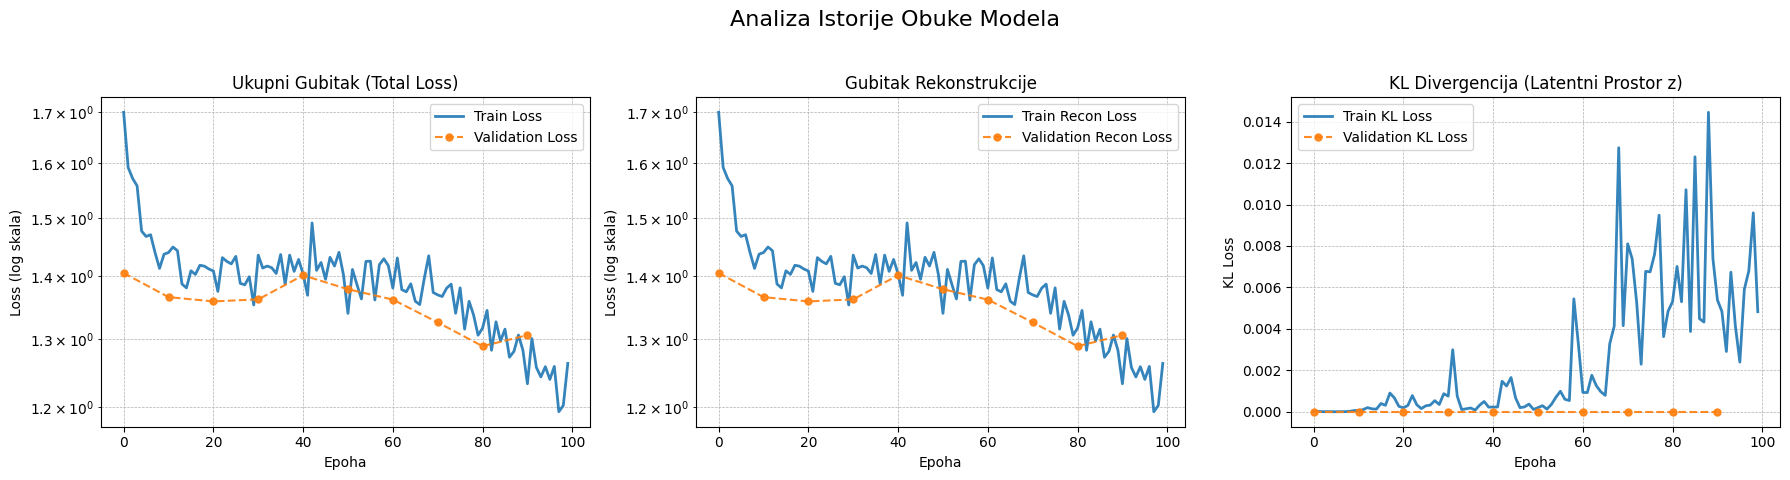

In [14]:
print("Generisanje plotova krivih učenja...")
# Broj epoha za trening
epochs_train = np.arange(len(history_data.get('loss_train', pd.Series())))

# Izračunavanje x-ose za validacione tačke
val_series = history_data.get('loss_val', pd.Series())
val_steps = len(val_series)
epochs_val = np.arange(val_steps) * validation_epochs

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Analiza Istorije Obuke Modela', fontsize=16)

# --- 1. Total Loss --- 
ax = axes[0]
if 'loss_train' in history_data:
    ax.plot(epochs_train, history_data['loss_train'], label='Train Loss', alpha=0.9, lw=2)
if 'loss_val' in history_data:
    ax.plot(epochs_val, val_series, label='Validation Loss', linestyle='--', marker='o', markersize=5, alpha=0.9)
ax.set_title('Ukupni Gubitak (Total Loss)')
ax.set_xlabel('Epoha')
ax.set_ylabel('Loss (log skala)')
ax.legend()
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- 2. Reconstruction Loss --- 
ax = axes[1]
if 'recon_loss_train' in history_data:
    ax.plot(epochs_train, history_data['recon_loss_train'], label='Train Recon Loss', alpha=0.9, lw=2)
if 'recon_loss_val' in history_data:
    val_recon_series = history_data.get('recon_loss_val', pd.Series())
    ax.plot(epochs_val[:len(val_recon_series)], val_recon_series, label='Validation Recon Loss', linestyle='--', marker='o', markersize=5, alpha=0.9)
ax.set_title('Gubitak Rekonstrukcije')
ax.set_xlabel('Epoha')
ax.set_ylabel('Loss (log skala)')
ax.legend()
ax.set_yscale('log')
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

# --- 3. KL Divergence Loss --- 
ax = axes[2]
if 'kl_loss_train' in history_data:
    ax.plot(epochs_train, history_data['kl_loss_train'], label='Train KL Loss', alpha=0.9, lw=2)
if 'kl_loss_val' in history_data:
    val_kl_series = history_data.get('kl_loss_val', pd.Series())
    ax.plot(epochs_val[:len(val_kl_series)], val_kl_series, label='Validation KL Loss', linestyle='--', marker='o', markersize=5, alpha=0.9)
ax.set_title('KL Divergencija (Latentni Prostor z)')
ax.set_xlabel('Epoha')
ax.set_ylabel('KL Loss')
ax.legend()
ax.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout(rect=[0, 0.03, 1, 0.95]) 
plt.show()


Prve dve krive (train i validation) treba da opadaju i da budu blizu jedna drugoj. Ako validacioni loss počne da raste dok trening loss i dalje opada, to je znak overfittinga. Ako obe krive ostanu visoko, model možda nije dovoljno kompleksan ili obuka nije trajala dovoljno dugo - underfitting. Ako je validacioni loss konstantno niži od trening loss-a, to je obično posledica regularizacije koja je aktivna samo tokom treninga.

Što se KL divergencije tiče, ako KL loss (posebno za validaciju) padne na veoma malu vrednost (blizu 0) i ostane tamo, to može biti znak posterior collapsea, gde model ignoriše latentni prostor z. Idealno, KL loss bi trebalo da konvergira ka nekoj stabilnoj pozitivnoj vrednosti, pokazujući da model aktivno koristi latentni prostor z za modeliranje stohastičnosti.